## **SKENARIO 1: Klasifikasi VBNN - Dimensional Reduction**

## **IMPORT LIBRARY**

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import math
from foronoi import Voronoi, Polygon
import time
from collections import namedtuple
from matplotlib.lines import Line2D

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

try:
    np.math
except AttributeError:
    np.math = math

try:
    np.float
except AttributeError:
    np.float = float  

## **DATA LOADING**

In [39]:
# Load dan read data
url_train = "https://drive.google.com/uc?export=download&id=1mwBc1Xbdp5vezgcQLi-BWcsaVNxiqblv"
url_test = "https://drive.google.com/uc?export=download&id=1nSQr83pGwZQ-ShLgrDWH0AoPEi3E5FgF"
url_label = "https://drive.google.com/uc?export=download&id=169-NXQYAKyntsfhcEjzWc0oNB4dD4DkQ"

df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_label = pd.read_csv(url_label)

In [40]:
# Menggabungkan fitur train dan label 
df = pd.concat([df_train, df_label], axis=1)
print(f"Dataset Loaded\nDimensi: {df.shape}")

Dataset Loaded
Dimensi: (3817, 17)


## **PREPROCESSING**

### - **Feature Engineering**

In [41]:
def feature_engineering(df_in):
    REF_YEAR = 2025
    REF_DATE = datetime(2025, 12, 31)

    df_out = df_in.copy()
    
    # 1. Fix Date Type
    df_out['tanggal_menjadi_anggota'] = pd.to_datetime(df_out['tanggal_menjadi_anggota'], errors='coerce')
    
    # 2. Feature: Umur
    df_out['umur'] = REF_YEAR - df_out['tahun_kelahiran']
    
    # 3. Feature: Lama Bergabung (Hari)
    df_out['lama_bergabung_hari'] = (REF_DATE - df_out['tanggal_menjadi_anggota']).dt.days
    
    # 4. Feature: Total Belanja
    col_belanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
    df_out[col_belanja] = df_out[col_belanja].fillna(0)
    df_out['total_belanja'] = df_out[col_belanja].sum(axis=1)

    # 5. Rata-rata belanja per kategori
    df_out['avg_belanja'] = df_out['total_belanja'] / 4

    # 6. Rasio belanja protein
    df_out['rasio_protein'] = (
        df_out['belanja_daging'] + df_out['belanja_ikan']
    ) / (df_out['total_belanja'] + 1)
    
    # Drop kolom mentah
    df_out.drop(columns=['tahun_kelahiran', 'tanggal_menjadi_anggota'], inplace=True, errors='ignore')
    
    return df_out

df_eng = feature_engineering(df)
print(f"Feature Engineering Selesai\nDimensi: {df_eng.shape}")

Feature Engineering Selesai
Dimensi: (3817, 20)


In [42]:
df_eng.head()

,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,jumlah_promosi,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein
0,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2,46,4258.0,382347.0,95586.75,0.814813
1,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,0,75,4672.0,151725.0,37931.25,0.826661
2,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,1,59,NaN,624985.0,156246.25,0.578895
3,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,4,64,NaN,1973840.0,493460.00,0.831691
4,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,4,55,NaN,476553.0,119138.25,0.738877


### - **Data Cleaning**

In [43]:
# Ganti noise '5' dengan NaN agar dianggap missing value
df_clean = df_eng.copy()

cols_with_noise = ['pendidikan', 'status_pernikahan']
for col in cols_with_noise:
    df_clean[col] = df_clean[col].replace('5', np.nan)

In [44]:
# Memisahkan Fitur (X) dan Target (y)
target_col = 'jumlah_promosi'
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [45]:
# Melakukan Split data
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Split Done. \nTrain Shape: {X_train_raw.shape}, Val Shape: {X_val_raw.shape}")

Data Split Done. 
Train Shape: (3053, 19), Val Shape: (764, 19)


In [46]:
X_train_clean = X_train_raw.copy()
X_val_clean = X_val_raw.copy()

In [47]:
X_train_clean.isnull().sum()

pendidikan              159
status_pernikahan       159
pendapatan              146
jumlah_anak_balita      148
jumlah_anak_remaja      161
terakhir_belanja        138
belanja_buah              0
belanja_daging            0
belanja_ikan              0
belanja_kue               0
pembelian_diskon        149
pembelian_web           139
pembelian_toko          144
keluhan                 166
umur                      0
lama_bergabung_hari    2201
total_belanja             0
avg_belanja               0
rasio_protein             0
dtype: int64

In [48]:
# Imputasi Missing Values

# Numeric (Median)
imputer_num = SimpleImputer(strategy='median')
X_train_clean[num_cols] = imputer_num.fit_transform(X_train_clean[num_cols])
X_val_clean[num_cols] = imputer_num.transform(X_val_clean[num_cols])

# Categorical (Mode)
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_clean[cat_cols] = imputer_cat.fit_transform(X_train_clean[cat_cols])
X_val_clean[cat_cols] = imputer_cat.transform(X_val_clean[cat_cols])

X_train_imp = pd.DataFrame(X_train_clean, columns=X_train_clean.columns, index=X_train_raw.index)
X_val_imp = pd.DataFrame(X_val_clean, columns=X_val_clean.columns, index=X_val_raw.index)

print("Missing Value Imputation Selesai")

Missing Value Imputation Selesai


In [49]:
X_train_imp.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
umur                   0
lama_bergabung_hari    0
total_belanja          0
avg_belanja            0
rasio_protein          0
dtype: int64

### - **FEATURE TRANSFORMATION**

In [50]:
# Melakukan encoding
X_train_enc = X_train_imp.copy()
X_val_enc = X_val_imp.copy()

# Ordinal Mapping (Pendidikan)
education_map = {'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5}
X_train_enc['pendidikan'] = X_train_enc['pendidikan'].map(education_map)
X_val_enc['pendidikan'] = X_val_enc['pendidikan'].map(education_map)

# One-Hot Encoding (Status Pernikahan)
X_train_enc = pd.get_dummies(X_train_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = pd.get_dummies(X_val_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoding selesai")

Encoding selesai


In [51]:
X_train_enc.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
700,3,111318457.0,0.0,1.0,64.0,31589.0,229295.0,17973.0,2139.0,5.0,4.0,7.0,0.0,68.0,4561.0,280996.0,70249.00,0.879967,0,0,0,1,0
2044,3,115264384.0,0.0,0.0,12.0,19006.0,12138.0,1957.0,24586.0,2.0,3.0,2.0,0.0,46.0,4561.0,57687.0,14421.75,0.244332,0,0,0,1,0
644,5,170943344.0,0.0,0.0,27.0,97241.0,1126126.0,145319.0,186336.0,2.0,4.0,10.0,0.0,73.0,4561.0,1555022.0,388755.50,0.817637,1,0,0,0,0
3218,3,102431000.0,0.0,2.0,63.0,208369.0,542164.0,151725.0,200277.0,3.0,9.0,12.0,0.0,54.0,4716.0,1102535.0,275633.75,0.629357,0,0,1,0,0
3393,3,152518651.0,0.0,0.0,9.0,136852.0,340312.0,137043.0,55036.0,2.0,10.0,4.0,0.0,65.0,4561.0,669243.0,167310.75,0.713275,0,0,0,0,1


In [52]:
# Handling Outliers 
X_train_out = X_train_enc.copy()
X_val_out = X_val_enc.copy()

def get_iqr_bounds(series, factor):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    return lower_bound, upper_bound


outlier_summary = []

num_cols = X_train_out.select_dtypes(include="number").columns.tolist()

for col in num_cols:
    mild_l, mild_u = get_iqr_bounds(X_train_out[col], 1.5)
    ext_l, ext_u = get_iqr_bounds(X_train_out[col], 3)
    vext_l, vext_u = get_iqr_bounds(X_train_out[col], 5)

    outlier_summary.append({
        "feature": col,
        "mild_outlier_pct (%)":
            ((X_train_out[col] < mild_l) | (X_train_out[col] > mild_u)).mean() * 100,
        "extreme_outlier_pct (%)":
            ((X_train_out[col] < ext_l) | (X_train_out[col] > ext_u)).mean() * 100,
        "very_extreme_outlier_pct (%)":
            ((X_train_out[col] < vext_l) | (X_train_out[col] > vext_u)).mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df

,feature,mild_outlier_pct (%),extreme_outlier_pct (%),very_extreme_outlier_pct (%)
0,pendidikan,2.325581,0.000000,0.000000
1,pendapatan,0.196528,0.000000,0.000000
2,jumlah_anak_balita,0.000000,0.000000,0.000000
3,jumlah_anak_remaja,0.000000,0.000000,0.000000
4,terakhir_belanja,0.000000,0.000000,0.000000
5,belanja_buah,7.402555,1.113659,0.000000
6,belanja_daging,4.192597,0.360301,0.000000
7,belanja_ikan,6.583688,0.425811,0.000000
8,belanja_kue,8.385195,1.244677,0.032755
9,pembelian_diskon,3.897805,0.458565,0.098264


In [53]:
cols_to_winsor = outlier_df.loc[
    outlier_df["mild_outlier_pct (%)"] > 1,
    "feature"
].tolist()

winsor_limits = {}

for col in cols_to_winsor:
    lower, upper = get_iqr_bounds(X_train_out[col], factor=1.5)
    winsor_limits[col] = (lower, upper)

for col, (lower, upper) in winsor_limits.items():
    X_train_out[col] = X_train_out[col].clip(lower, upper)
    X_val_out[col] = X_val_out[col].clip(lower, upper)

print("Handling outliers selesai")

Handling outliers selesai


In [54]:
X_train_out.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
700,3.0,111318457.0,0.0,1.0,64.0,31589.0,229295.0,17973.0,2139.0,5.0,4.0,7.0,0.0,68.0,4561.0,280996.0,70249.00,0.879967,0,0,0,1,0
2044,3.0,115264384.0,0.0,0.0,12.0,19006.0,12138.0,1957.0,24586.0,2.0,3.0,2.0,0.0,46.0,4561.0,57687.0,14421.75,0.430634,0,0,0,1,0
644,5.0,170943344.0,0.0,0.0,27.0,97241.0,1126126.0,145319.0,186336.0,2.0,4.0,10.0,0.0,73.0,4561.0,1555022.0,388755.50,0.817637,0,0,0,0,0
3218,3.0,102431000.0,0.0,2.0,63.0,191929.0,542164.0,151725.0,197347.0,3.0,9.0,12.0,0.0,54.0,4561.0,1102535.0,275633.75,0.629357,0,0,1,0,0
3393,3.0,152518651.0,0.0,0.0,9.0,136852.0,340312.0,137043.0,55036.0,2.0,10.0,4.0,0.0,65.0,4561.0,669243.0,167310.75,0.713275,0,0,0,0,1


In [55]:
# Melakukan Scaling
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_out),
    columns=X_train_out.columns,
    index=X_train_out.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_out),
    columns=X_val_out.columns,
    index=X_val_out.index
)

print("Scaling selesai")

Scaling selesai


In [56]:
X_train_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
700,0.0,-0.059931,0.0,1.0,0.395349,0.119889,0.053880,-0.121824,-0.288280,1.5,0.00,0.4,0.0,0.647059,0.0,-0.035931,-0.035931,0.371332,0.0,0.0,0.0,1.0,0.0
2044,0.0,0.000000,0.0,0.0,-0.813953,-0.049365,-0.303887,-0.269279,0.004037,0.0,-0.25,-0.6,0.0,-0.647059,0.0,-0.279728,-0.279728,-2.111294,0.0,0.0,0.0,1.0,0.0
644,2.0,0.845660,0.0,0.0,-0.465116,1.002973,1.531412,1.050619,2.110431,0.0,0.00,1.0,0.0,0.941176,0.0,1.354978,1.354978,0.026954,0.0,0.0,0.0,0.0,0.0
3218,0.0,-0.194915,0.0,2.0,0.372093,2.276619,0.569333,1.109597,2.253822,0.5,1.25,1.4,0.0,-0.176471,0.0,0.860978,0.860978,-1.013320,0.0,0.0,1.0,0.0,0.0
3393,0.0,0.565823,0.0,0.0,-0.883721,1.535780,0.236781,0.974424,0.400573,0.0,1.50,-0.2,0.0,0.470588,0.0,0.387935,0.387935,-0.549663,0.0,0.0,0.0,0.0,1.0


### - **DIMENSIONAL REDUCTION**

In [57]:
pca = PCA(n_components=2, whiten=False, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

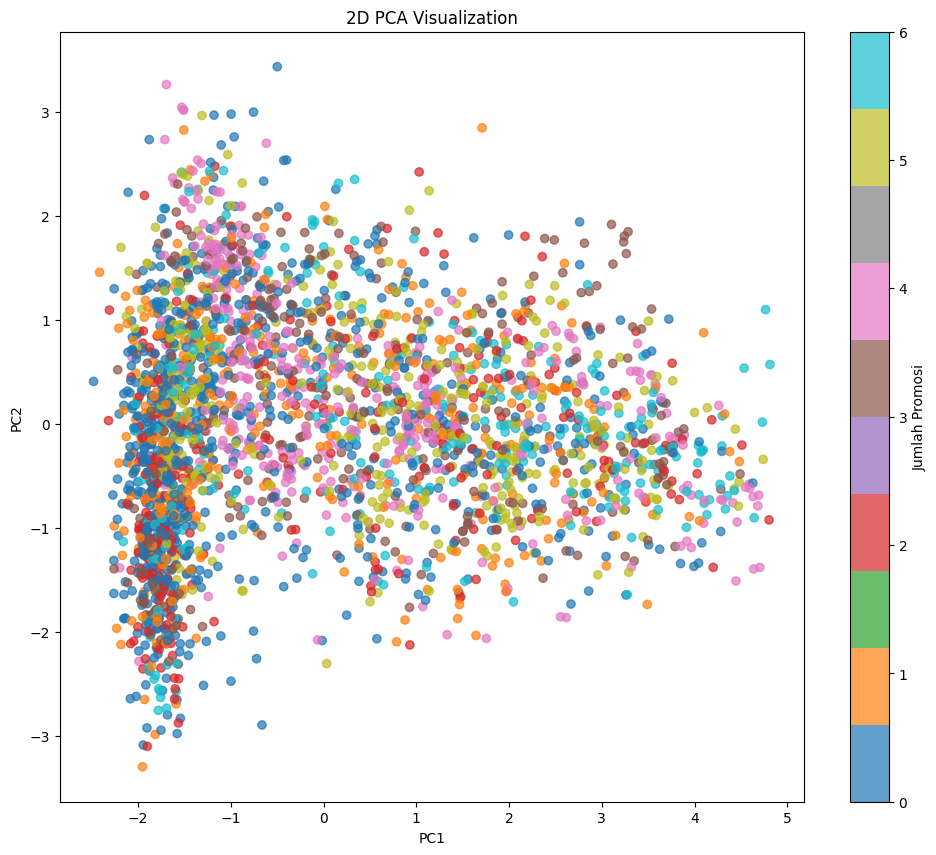

In [58]:
plt.figure(figsize=(12, 10))

sc = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=y_train,
    cmap='tab10',
    alpha=0.7
)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA Visualization')

plt.colorbar(sc, label='Jumlah Promosi')
plt.show()

In [59]:
pca_cols = [f"PCA_{i+1}" for i in range(X_train_pca.shape[1])]

X_train_final = pd.DataFrame(
    X_train_pca,
    columns=pca_cols,
    index=X_train_scaled.index
)

X_val_final = pd.DataFrame(
    X_val_pca,
    columns=pca_cols,
    index=X_val_scaled.index
)

# Menampilkan explained variance ratio
explained_var = pca.explained_variance_ratio_
cum_explained_var = explained_var.cumsum()

for i, (var, cum_var) in enumerate(zip(explained_var, cum_explained_var), start=1):
    print(f"PC{i}: {var:.4f} | Cumulative: {cum_var:.4f}")

PC1: 0.3609 | Cumulative: 0.3609
PC2: 0.1197 | Cumulative: 0.4807


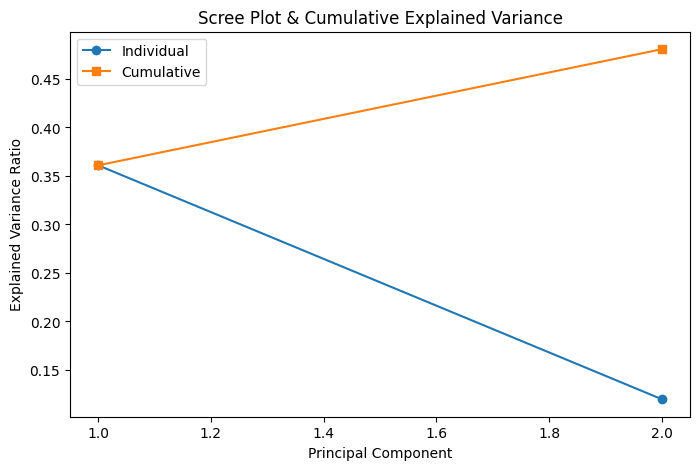

In [60]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.plot(range(1, len(cum_explained_var) + 1), cum_explained_var, marker='s')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot & Cumulative Explained Variance')
plt.legend(['Individual', 'Cumulative'])
plt.show()

In [61]:
X_train_final.head()

,PCA_1,PCA_2
700,-1.049594,1.223980
2044,-1.478036,-1.430130
644,2.864619,1.276039
3218,2.206919,-0.037536
3393,0.939426,-0.064147


## **MANUAL CALCULATION**

In [62]:
# train_sample = X_train_final.iloc[:5]
# val_sample = X_val_final.iloc[:1]

In [63]:
# dists = []
# for i in range(len(train_sample)):
#     # Euclidean Distance
#     d = np.linalg.norm(train_sample.iloc[i] - val_sample.iloc[0])
#     dists.append(d)

In [64]:
# # untuk k=3
# manual_res = pd.DataFrame({
#     'Train_Idx': train_sample.index, 
#     'Dist': dists, 
#     'Label': y_train.iloc[:5].values
# }).sort_values('Dist')
# manual_res.head(3)

## **MODELING**

In [65]:
Node = namedtuple('Node', ['point', 'label', 'left', 'right', 'axis'])

class CustomKDTree:
    def __init__(self, X, y):
        self.k = X.shape[1] 
        self.root = self._build_tree(X, y)

    def _build_tree(self, points, labels, depth=0):
        n = len(points)
        if n == 0:
            return None
        axis = depth % self.k
        
        # Gabungkan point dan label
        combined = list(zip(points, labels))
        combined.sort(key=lambda x: x[0][axis])
        mid = n // 2
        
        return Node(
            point=combined[mid][0],
            label=combined[mid][1],
            left=self._build_tree([p for p, l in combined[:mid]], 
                                  [l for p, l in combined[:mid]], depth + 1),
            right=self._build_tree([p for p, l in combined[mid+1:]], 
                                   [l for p, l in combined[mid+1:]], depth + 1),
            axis=axis
        )

    def _distance(self, p1, p2):
        return np.sqrt(np.sum((p1 - p2) ** 2))

    def _search_nearest(self, node, target, best=None):
        if node is None:
            return best

        dist = self._distance(node.point, target)

        # Update best: simpan (Jarak, Label, KOORDINAT_ASLI)
        if best is None or dist < best[0]:
            best = (dist, node.label, node.point) 

        axis = node.axis
        diff = target[axis] - node.point[axis]

        if diff < 0:
            near_node, far_node = node.left, node.right
        else:
            near_node, far_node = node.right, node.left

        best = self._search_nearest(near_node, target, best)

        if abs(diff) < best[0]:
            best = self._search_nearest(far_node, target, best)

        return best

    def query(self, X):
        """Hanya mengembalikan Label (Untuk evaluasi akurasi)"""
        predictions = []
        for x in X:
            # best = (jarak, label, point) -> ambil label index 1
            best_tuple = self._search_nearest(self.root, x)
            predictions.append(best_tuple[1]) 
        return np.array(predictions)
    
    def query_complete(self, x_single):
        """
        Fitur Khusus Visualisasi:
        Mengembalikan (Label, Koordinat_Tetangga)
        Menggunakan pencarian Tree murni.
        """
        # best = (jarak, label, point)
        best_tuple = self._search_nearest(self.root, x_single)
        return best_tuple[1], best_tuple[2] # Return Label dan Point

In [66]:
class VBNN:
    def __init__(self):
        self.voronoi = None       
        self.tree = None          
        self.X_train = None
        self.y_train = None
        
    def fit(self, X, y):
        # Persiapan Data
        self.X_train = np.array(X)[:, :2] 
        self.y_train = np.array(y)
        
        # KONSTRUKSI VORONOI
        margin = 10
        x_min = float(self.X_train[:, 0].min() - margin)
        x_max = float(self.X_train[:, 0].max() + margin)
        y_min = float(self.X_train[:, 1].min() - margin)
        y_max = float(self.X_train[:, 1].max() + margin)
        
        polygon = Polygon([
            (x_min, y_min), (x_max, y_min), 
            (x_max, y_max), (x_min, y_max)
        ])
        
        self.voronoi = Voronoi(polygon)
        sites = [(float(x), float(y)) for x, y in self.X_train]
        print("Membangun Diagram Voronoi...")
        self.voronoi.create_diagram(sites)
        print("OK")
        
        print("Membangun k-d Tree...")
        self.tree = CustomKDTree(self.X_train, self.y_train)
        print("OK")
        
    def predict(self, X):
        X = np.array(X)[:, :2]
        return self.tree.query(X)

    def visualize_structure(self):
        """
        Visualisasi Final:
        - Legenda di bawah grafik (horizontal).
        - Warna estetik.
        - Titik dan garis rapi.
        """
        # Ukuran figure disesuaikan agar ada ruang untuk legenda di bawah
        plt.figure(figsize=(12, 11)) 
        print("Menggambar Visualisasi VBNN...")
        
        # --- CONFIG COLORS ---
        edge_color = '#E67E22'  # Orange Pumpkin
        point_color = 'royalblue'
        
        # --- 1. GAMBAR GARIS BATAS VORONOI ---
        for edge in self.voronoi.edges:
            if hasattr(edge, 'origin') and hasattr(edge, 'target'):
                if edge.origin is not None and edge.target is not None:
                    x_pts = [edge.origin.x, edge.target.x]
                    y_pts = [edge.origin.y, edge.target.y]
                    
                    plt.plot(x_pts, y_pts, 
                             c=edge_color, 
                             linewidth=0.8, 
                             alpha=0.6,    # Transparan biar tidak terlalu dominan
                             zorder=1)     # Di lapisan bawah
        
        # --- 2. GAMBAR TITIK DATA LATIH ---
        plt.scatter(self.X_train[:, 0], self.X_train[:, 1], 
                    c=point_color, 
                    s=5,           # Ukuran titik kecil agar rapi
                    zorder=2)      # Di lapisan atas
        
        # --- 3. ATUR ZOOM OTOMATIS ---
        x_min_view = np.percentile(self.X_train[:, 0], 1) - 2
        x_max_view = np.percentile(self.X_train[:, 0], 99) + 2
        y_min_view = np.percentile(self.X_train[:, 1], 1) - 2
        y_max_view = np.percentile(self.X_train[:, 1], 99) + 2
        
        plt.xlim(x_min_view, x_max_view)
        plt.ylim(y_min_view, y_max_view)
        
        # --- 4. JUDUL & LABEL ---
        plt.title("Visualisasi Struktur VBNN dan Batas Keputusan", fontsize=16, fontweight='bold', pad=15)
        plt.xlabel("PCA 1", fontsize=12)
        plt.ylabel("PCA 2", fontsize=12)
        
        # --- 5. LEGENDA KUSTOM DI BAWAH (THE FIX) ---
        # Kita buat ikon palsu agar tampilan di legenda lebih jelas/besar
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Titik Data Latih (Point Generators)',
                   markerfacecolor=point_color, markersize=10),
            
            Line2D([0], [0], color=edge_color, lw=2, label='Batas Sel Voronoi (Decision Boundary)')
        ]
        
        plt.legend(handles=legend_elements, loc='lower center', ncol=4, 
               bbox_to_anchor=(0.5, -0.1), fontsize=12, frameon=False)

        # tight_layout akan menyesuaikan margin agar legenda tidak terpotong
        plt.tight_layout()
        plt.show()

===== TRAINING MODEL VBNN =====
Membangun Diagram Voronoi...
OK
Membangun k-d Tree...
OK
Waktu Training: 2.9204 detik

===== VISUALISASI DIAGRAM VORONOI =====
Menggambar Visualisasi VBNN...


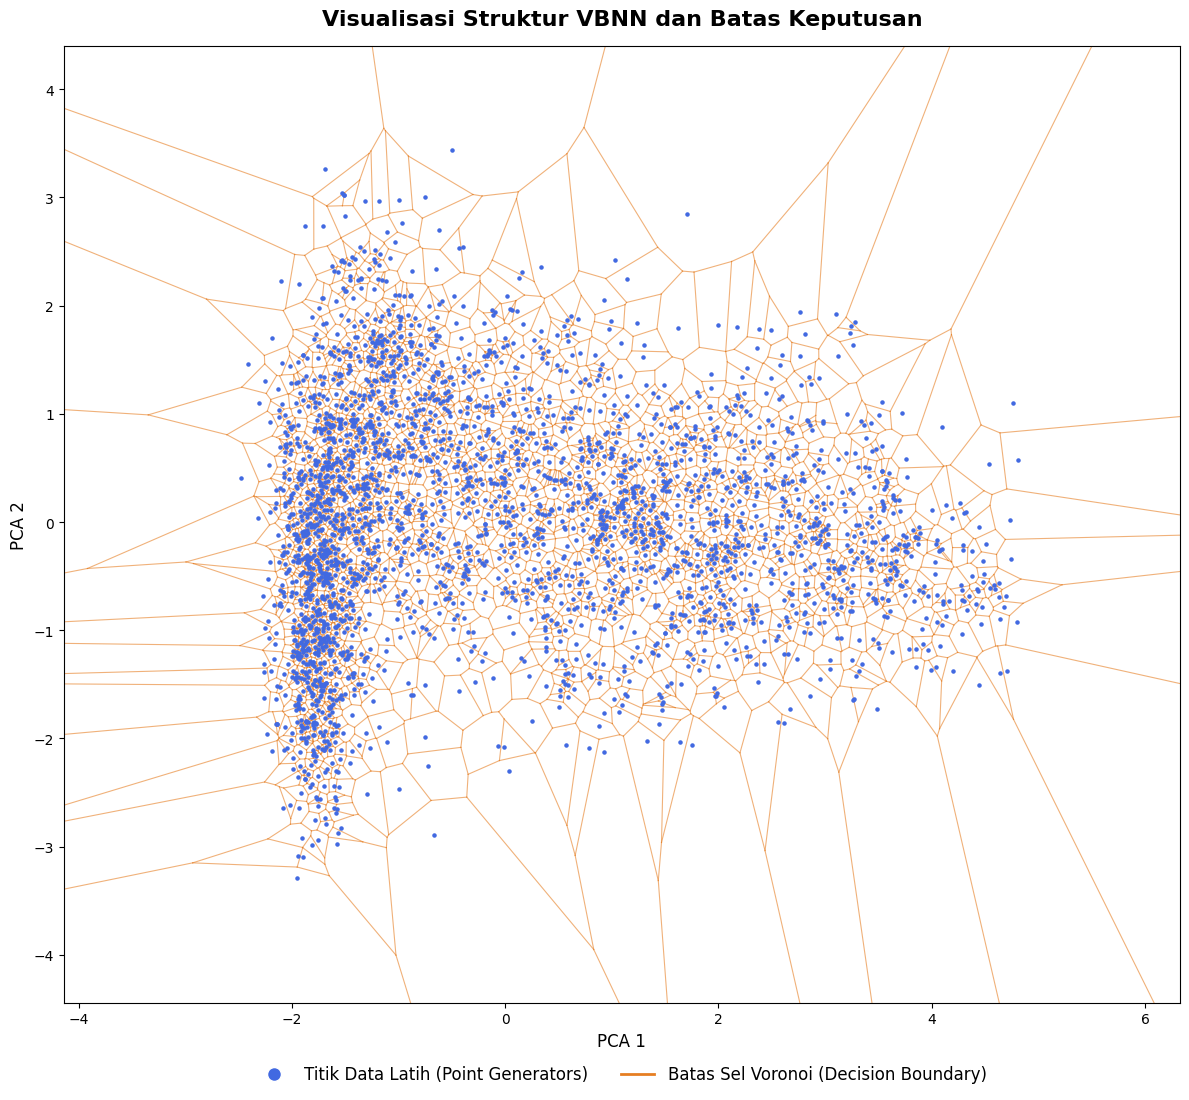

In [67]:
# Training Phase
model = VBNN()

print("===== TRAINING MODEL VBNN =====")
start_train = time.time()
model.fit(X_train_final.values, y_train.values)
print(f"Waktu Training: {time.time() - start_train:.4f} detik")

# Visualization Phase
print("\n===== VISUALISASI DIAGRAM VORONOI =====")
if model.voronoi is not None:
    model.visualize_structure()

## **EVALUATION**

In [68]:
start_pred = time.time()
y_pred_vbnn = model.predict(X_val_final.values)
time_pred = time.time() - start_pred

f1_macro = f1_score(y_val.values, y_pred_vbnn, average="macro")
accuracy = accuracy_score(y_val.values, y_pred_vbnn)

print(f"Accuracy      : {accuracy * 100:.2f}%")
print(f"Macro F1 Score : {f1_macro * 100:.2f}%")
print(f"Waktu Prediksi : {time_pred:.4f} detik\n")

print("Classification Report:")
print(classification_report(y_val.values, y_pred_vbnn))

Accuracy      : 25.79%
Macro F1 Score : 22.62%
Waktu Prediksi : 0.0945 detik

Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.39      0.36       195
           1       0.24      0.18      0.21       120
           2       0.12      0.10      0.11        79
           3       0.17      0.15      0.16        84
           4       0.32      0.38      0.35        91
           5       0.27      0.28      0.28       120
           6       0.12      0.11      0.11        75

    accuracy                           0.26       764
   macro avg       0.23      0.23      0.23       764
weighted avg       0.25      0.26      0.25       764



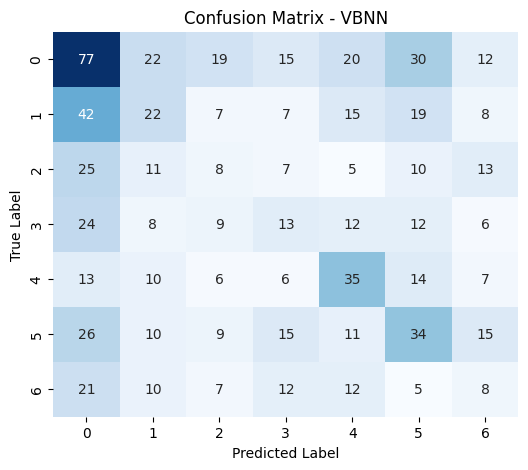

In [69]:
# Confusion Matrix
cm = confusion_matrix(y_val.values, y_pred_vbnn)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - VBNN")
plt.show()

In [70]:
# Cross-Validation 
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

f1_scores = []
acc_scores = []
pred_times = []

print("===== Cross Validation VBNN =====")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_final, y_train), 1):
    X_tr, X_va = X_train_final.values[train_idx], X_train_final.values[val_idx]
    y_tr, y_va = y_train.values[train_idx], y_train.values[val_idx]

    model_cv = VBNN()
    model_cv.fit(X_tr, y_tr)

    start = time.time()
    y_pred = model_cv.predict(X_va)
    pred_time = time.time() - start

    f1 = f1_score(y_va, y_pred, average="macro")
    acc = accuracy_score(y_va, y_pred)

    # Simpan hasil
    f1_scores.append(f1)
    acc_scores.append(acc)
    pred_times.append(pred_time)

    # Tampilkan per fold
    print(
        f"Fold {fold:>2} | "
        f"Macro F1: {f1*100:6.2f}% | "
        f"Akurasi: {acc*100:6.2f}% | "
        f"Waktu Prediksi: {pred_time:.4f} detik"
    )

# Ringkasan
print("\n===== Ringkasan CV =====")
print(f"Macro F1 Mean : {np.mean(f1_scores)*100:.2f}%")
print(f"Macro F1 Std  : {np.std(f1_scores)*100:.2f}%")
print(f"Akurasi Mean : {np.mean(acc_scores)*100:.2f}%")
print(f"Akurasi Std  : {np.std(acc_scores)*100:.2f}%")
print(f"Avg Predict Time : {np.mean(pred_times):.4f} detik")

===== Cross Validation VBNN =====
Membangun Diagram Voronoi...
OK
Membangun k-d Tree...
OK
Fold  1 | Macro F1:  25.17% | Akurasi:  26.51% | Waktu Prediksi: 0.0338 detik
Membangun Diagram Voronoi...
OK
Membangun k-d Tree...
OK
Fold  2 | Macro F1:  22.93% | Akurasi:  26.02% | Waktu Prediksi: 0.0332 detik
Membangun Diagram Voronoi...
OK
Membangun k-d Tree...
OK
Fold  3 | Macro F1:  21.63% | Akurasi:  23.24% | Waktu Prediksi: 0.0385 detik
Membangun Diagram Voronoi...
OK
Membangun k-d Tree...
OK
Fold  4 | Macro F1:  21.93% | Akurasi:  23.93% | Waktu Prediksi: 0.0350 detik
Membangun Diagram Voronoi...
OK
Membangun k-d Tree...
OK
Fold  5 | Macro F1:  19.01% | Akurasi:  21.48% | Waktu Prediksi: 0.0371 detik

===== Ringkasan CV =====
Macro F1 Mean : 22.13%
Macro F1 Std  : 1.99%
Akurasi Mean : 24.24%
Akurasi Std  : 1.85%
Avg Predict Time : 0.0355 detik


=== Menjalankan Visualisasi Incremental Update (Beautified) ===
Membangun Model Awal...
Membangun Diagram Voronoi...
OK
Membangun k-d Tree...
OK
Mengupdate Model...
Membangun Diagram Voronoi...
OK
Membangun k-d Tree...
OK


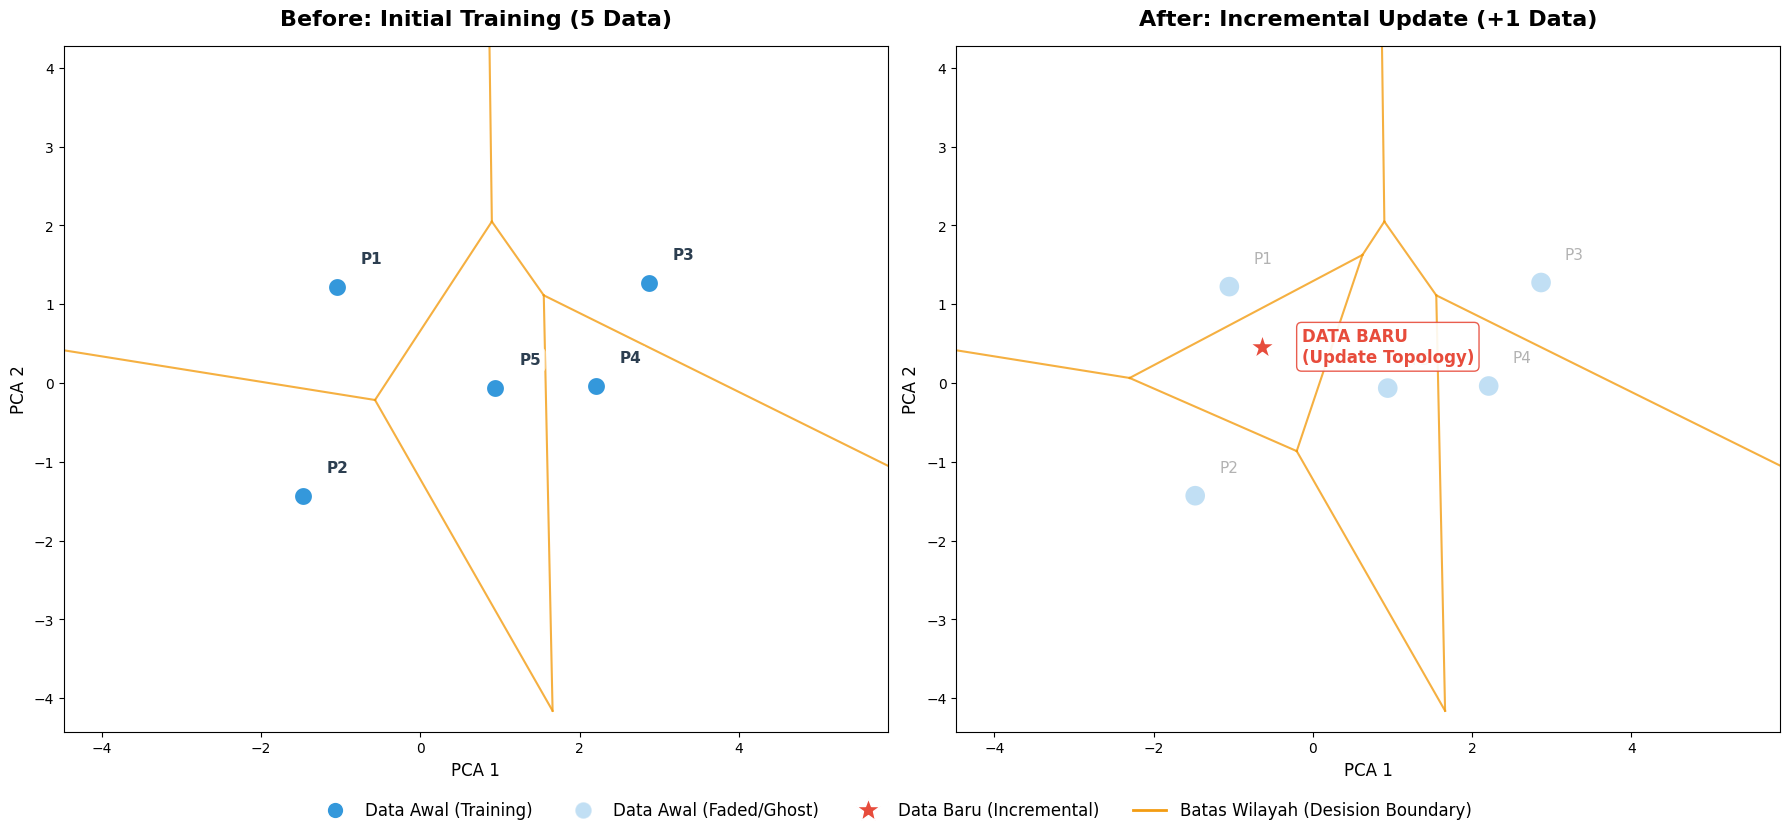

In [71]:
def visualize_update_diagram(model_class, X_train, y_train, X_val, y_val):
    """
    Simulasi Incremental Learning (Beautified Version)
    """
    # 1. PERSIAPAN DATA
    X_initial = X_train[:5]
    y_initial = y_train[:5]
    
    new_point = X_val[0]
    new_label = y_val[0]
    
    # Gabungan
    X_updated = np.vstack([X_initial, new_point])
    y_updated = np.append(y_initial, new_label)
    
    # --- SETUP TAMPILAN ---
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Style Config
    color_line = '#F39C12'   # Orange Pumpkin
    color_train = '#3498DB'  # Royal Blue
    color_new = '#E74C3C'    # Alizarin Red
    
    # Tentukan batas zoom yang konsisten
    margin = 3
    x_min, x_max = X_updated[:, 0].min() - margin, X_updated[:, 0].max() + margin
    y_min, y_max = X_updated[:, 1].min() - margin, X_updated[:, 1].max() + margin
    
    # --- PLOT 1: KONDISI AWAL ---
    print("Membangun Model Awal...")
    model_A = model_class()
    model_A.fit(X_initial, y_initial)
    
    ax = axes[0]
    # A. Garis Voronoi
    for edge in model_A.voronoi.edges:
        if hasattr(edge, 'origin') and hasattr(edge, 'target'):
            if edge.origin is not None and edge.target is not None:
                ax.plot([edge.origin.x, edge.target.x], [edge.origin.y, edge.target.y], 
                        c=color_line, linewidth=1.5, alpha=0.8, zorder=1)
    
    # B. Titik Training (Dengan White Border biar pop-up)
    ax.scatter(X_initial[:, 0], X_initial[:, 1], c=color_train, s=200, 
               edgecolors='white', linewidth=2, zorder=3)
    
    # C. Label P1-P5 (Pakai Background Box biar kebaca)
    for i, txt in enumerate(range(len(X_initial))):
        ax.text(X_initial[i, 0] + 0.3, X_initial[i, 1] + 0.3, f"P{i+1}", 
                fontsize=11, fontweight='bold', color='#2C3E50',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

    ax.set_title("Before: Initial Training (5 Data)", fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel("PCA 1", fontsize=12)
    ax.set_ylabel("PCA 2", fontsize=12)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # --- PLOT 2: SETELAH UPDATE ---
    print("Mengupdate Model...")
    model_B = model_class()
    model_B.fit(X_updated, y_updated)
    
    ax = axes[1]
    # A. Garis Voronoi Baru
    for edge in model_B.voronoi.edges:
        if hasattr(edge, 'origin') and hasattr(edge, 'target'):
            if edge.origin is not None and edge.target is not None:
                ax.plot([edge.origin.x, edge.target.x], [edge.origin.y, edge.target.y], 
                        c=color_line, linewidth=1.5, alpha=0.8, zorder=1)
    
    # B. Titik Lama (Faded/Ghost Effect)
    ax.scatter(X_initial[:, 0], X_initial[:, 1], c=color_train, s=200, 
               alpha=0.3, edgecolors='none', zorder=2) # Alpha rendah = Faded
    
    for i, txt in enumerate(range(len(X_initial))):
        ax.text(X_initial[i, 0] + 0.3, X_initial[i, 1] + 0.3, f"P{i+1}", 
                fontsize=11, color='gray', alpha=0.6)

    # C. Titik BARU (Star Shape & Merah)
    ax.scatter(new_point[0], new_point[1], c=color_new, s=400, marker='*', 
               edgecolors='white', linewidth=1.5, zorder=4, label='New Data')
    
    # Label "DATA BARU"
    ax.text(new_point[0] + 0.5, new_point[1], "DATA BARU\n(Update Topology)", 
            color=color_new, fontweight='bold', fontsize=12, va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color_new, alpha=0.9))
    
    ax.set_title("After: Incremental Update (+1 Data)", fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel("PCA 1", fontsize=12)
    ax.set_ylabel("PCA 2", fontsize=12)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # --- LEGEND KUSTOM (SHARED) ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_train, markersize=12, label='Data Awal (Training)'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_train, markersize=12, alpha=0.3, label='Data Awal (Faded/Ghost)'),
        Line2D([0], [0], marker='*', color='w', markerfacecolor=color_new, markersize=18, label='Data Baru (Incremental)'),
        Line2D([0], [0], color=color_line, lw=2, label='Batas Wilayah (Desision Boundary)')
    ]
    
    # Taruh legend di tengah bawah figure
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
               bbox_to_anchor=(0.5, -0.05), fontsize=12, frameon=False)

    plt.tight_layout()
    plt.show()

# --- EKSEKUSI ---
print("=== Menjalankan Visualisasi Incremental Update (Beautified) ===")
visualize_update_diagram(
    VBNN, 
    X_train_final.values, 
    y_train.values, 
    X_val_final.values, 
    y_val.values
)

===== Menjalankan Visualisasi Prediksi =====
Membangun Diagram Voronoi...
OK
Membangun k-d Tree...
OK
Hasil Point Location: Titik koordinat wilayah terdekat [-1.04959369  1.22398044], Label 4


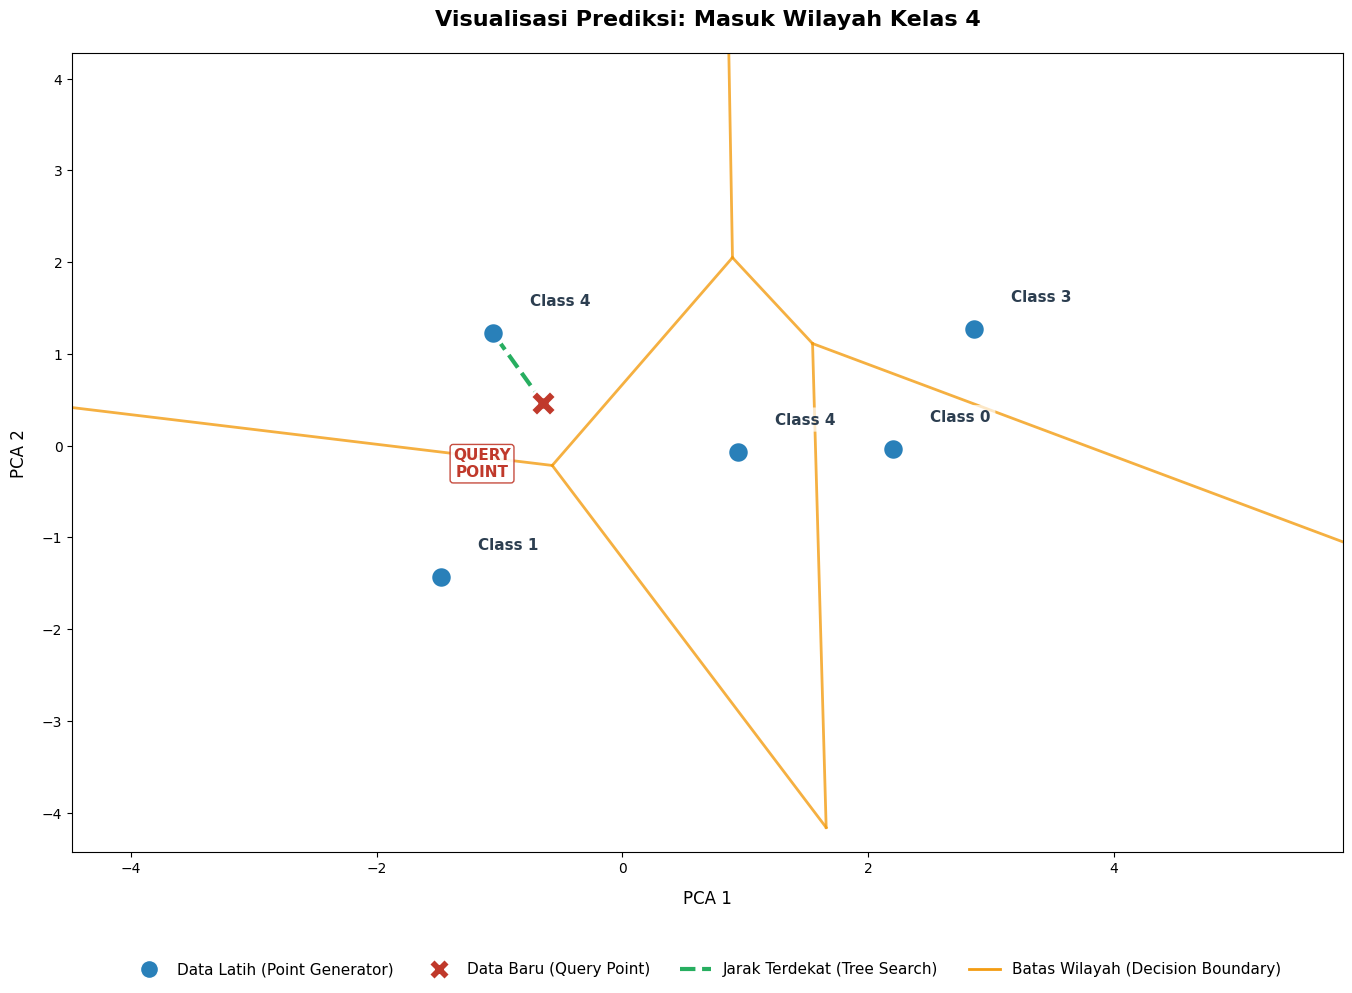

In [72]:
def visualize_prediction(model_class, X_train, y_train, X_val, y_val):
    """
    Visualisasi Prediksi Final (Fixed Boundaries & Labels)
    """
    # 1. AMBIL DATA (5 Data Latih + 1 Data Baru)
    X_train_small = X_train[:5]
    y_train_small = y_train[:5]
    query_point = X_val[0]   
    
    # 2. TRAINING MODEL
    model = model_class()
    model.fit(X_train_small, y_train_small)
    
    # 3. PREDIKSI (TREE SEARCH)
    pred_label, nearest_neighbor_coords = model.tree.query_complete(query_point)
    print(f"Hasil Point Location: Titik koordinat wilayah terdekat {nearest_neighbor_coords}, Label {pred_label}")
    
    # --- SETUP TAMPILAN ---
    plt.figure(figsize=(14, 10))
    
    # Style Config (Warna Flat Design)
    color_line = '#F39C12'   # Orange Pumpkin (Garis)
    color_train = '#2980B9'  # Belgrade Blue (Data Latih)
    color_new = '#C0392B'    # Old Brick (Data Baru)
    color_conn = '#27AE60'   # Nephritis Green (Koneksi)
    
    # A. Gambar Peta Voronoi
    if model.voronoi is not None:
        for edge in model.voronoi.edges:
            if hasattr(edge, 'origin') and hasattr(edge, 'target'):
                if edge.origin is not None and edge.target is not None:
                    plt.plot([edge.origin.x, edge.target.x], [edge.origin.y, edge.target.y], 
                             c=color_line, linewidth=2, alpha=0.8, zorder=1)

    # B. Gambar Data Latih (Generator)
    plt.scatter(X_train_small[:, 0], X_train_small[:, 1], c=color_train, s=250, 
                edgecolors='white', linewidth=2.5, zorder=3)
    
    # Labeling Data Latih
    for i in range(len(X_train_small)):
        plt.text(X_train_small[i, 0] + 0.3, X_train_small[i, 1] + 0.3, f"Class {y_train_small[i]}", 
                 fontsize=11, fontweight='bold', color='#2C3E50',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

    # C. Gambar Data Baru (Query Point)
    plt.scatter(query_point[0], query_point[1], c=color_new, s=350, marker='X', 
                edgecolors='white', linewidth=2, zorder=4)
    
    # Label Query Point
    plt.text(query_point[0] - 0.5, query_point[1] - 0.8, "QUERY\nPOINT", 
             color=color_new, fontweight='bold', fontsize=11, ha='center',
             bbox=dict(boxstyle="round,pad=0.2", fc="white", ec=color_new, alpha=0.9))
    
    # D. Gambar Garis Koneksi (Nearest Neighbor)
    plt.plot([query_point[0], nearest_neighbor_coords[0]], [query_point[1], nearest_neighbor_coords[1]], 
             c=color_conn, linestyle='--', linewidth=3, zorder=2)
    
    # --- SETUP ZOOM & LABEL (FIXED) ---
    view_margin = 3 
    
    all_points = np.vstack([X_train_small, query_point])
    plt.xlim(all_points[:, 0].min() - view_margin, all_points[:, 0].max() + view_margin)
    plt.ylim(all_points[:, 1].min() - view_margin, all_points[:, 1].max() + view_margin)
    
    # Label Sumbu (Wajib Ada)
    plt.xlabel("PCA 1", fontsize=12, labelpad=10)
    plt.ylabel("PCA 2", fontsize=12, labelpad=10)

    plt.title(f"Visualisasi Prediksi: Masuk Wilayah Kelas {pred_label}", fontsize=16, fontweight='bold', pad=20)
    
    # --- LEGEND KUSTOM DI BAWAH ---
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color_train, markersize=13, label='Data Latih (Point Generator)'),
        Line2D([0], [0], marker='X', color='w', markerfacecolor=color_new, markersize=15, label='Data Baru (Query Point)'),
        Line2D([0], [0], color=color_conn, lw=3, linestyle='--', label='Jarak Terdekat (Tree Search)'),
        Line2D([0], [0], color=color_line, lw=2, label='Batas Wilayah (Decision Boundary)')
    ]
    
    # Posisi Legend di Bawah Tengah
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.12),
               ncol=4, fontsize=11, frameon=False)
    
    plt.tight_layout()
    plt.show()

# --- EKSEKUSI ---
print("===== Menjalankan Visualisasi Prediksi =====")
visualize_prediction(
    VBNN, 
    X_train_final.values, 
    y_train.values, 
    X_val_final.values, 
    y_val.values
)